As the outcome of validation data are available, I'll refit the prep pipeline and models to make prediction.

In [9]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import joblib
import itertools
import compose
%matplotlib inline


import sys
import os
import warnings
sys.path.append(os.path.join(
    os.path.abspath(os.path.pardir), 'src'
))

import nzcompetition
from nzcompetition.preparation import make_prep_pipeline
from nzcompetition.plots import plot_train_pred, plot_pred_distribution

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from libdl.dl import dl

y_col = 'performance'
y_col_raw = 'TOM Wash PT Model X'
# for plotting
lim=[0, 1.5]

random_state=190624

# Data

In [3]:
X_train, y, X_val = nzcompetition.get_raw_data(target=y_col)
X_train, y = nzcompetition.drop_dup(X_train, y)
X_train = nzcompetition.drop_tom(X_train)
X_val = nzcompetition.drop_tom(X_val)

In [4]:
X_test = nzcompetition.get_test_data()

In [5]:
print(X_train.shape, y.shape, X_val.shape, X_test.shape)

(122, 108) (122,) (61, 108) (60, 108)


### Outcomes of validation set

Full validation set with outcomes are in file `validation`.

In [6]:
y_val = (
    dl.datasets.get(id='nz_kaggle')
    .files.get(id='validation')
    .as_df()
    .set_index(["Organism Code", "purifiedsample_sequoia_identifier"])
    [y_col_raw]
)

### Full training set

In [7]:
X = pd.concat([X_train, X_val])
X.shape

(183, 108)

In [8]:
y = pd.concat([y, y_val])

# TFF10N_adaboost

In [50]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=RuntimeWarning)
    prep_pipe = make_prep_pipeline(True, False, False, 1.0)
    X_prep = prep_pipe.fit_transform(X)
    X_test_prep = prep_pipe.transform(X_test)

In [45]:
ada_reg = joblib.load('../models/submission/perf_TFF10N_adaboost.pkl')

In [12]:
cvs = cross_val_score(ada_reg, X_prep, y, scoring='neg_mean_squared_error', cv=5)
print(cvs, np.mean(cvs))

[-0.05718785 -0.02975486 -0.0315894  -0.03056152 -0.05725131] -0.04126898801423547


In [13]:
ada_reg.fit(X_prep, y)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=5,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=7,
                                                       min_samples_split=6,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=1.1944007321572443, loss='linear',
                  n_estimato

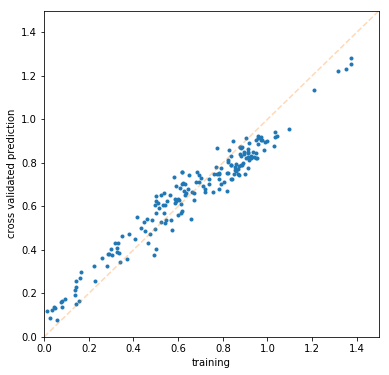

In [22]:
plot_train_pred(y, ada_reg.predict(X_prep), lim)

In [23]:
mean_squared_error(y, ada_reg.predict(X_prep))

0.006573737483641775

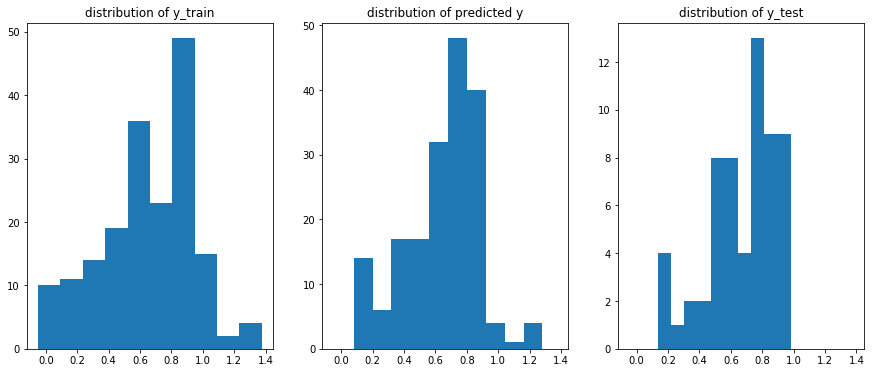

In [24]:
plot_pred_distribution(y, ada_reg.predict(X_prep), ada_reg.predict(X_test_prep))

In [25]:
pd.DataFrame(
    ada_reg.predict(X_test_prep), 
    index=X_test.droplevel('Organism Code').index, 
    columns=['pred'], 
    dtype='float'
).to_csv('../output/submission/perf_TFF10N_adaboost_refit_with_val.csv')

In [26]:
joblib.dump(ada_reg, '../models/submission/perf_TFF10N_adaboost_refit_with_val.pkl')

['../models/submission/perf_TFF10N_adaboost_refit_with_val.pkl']

This prediction got an MSE `0.0134` in test set.

### xgboost

In [ ]:
import xgboost

In [65]:
xgb_reg = xgboost.XGBRegressor(
    max_depth=5, 
    objective='reg:squarederror', 
    subsample=0.8,
    reg_alpha=0.3,
    reg_lambda=1,
    random_state=random_state, 
)

In [66]:
cvs = cross_val_score(
    xgb_reg, X_prep, y, scoring='neg_mean_squared_error', cv=5)
print(cvs, np.mean(cvs))

/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[-0.05611915 -0.02876693 -0.03037001 -0.0289089  -0.0561071 ] -0.04005441877276809


/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Thus we can explore XGBoost more.

In [72]:
from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV
)

from scipy.stats import (
    randint, 
    expon, 
    reciprocal, 
    uniform, 
    norm,
)

In [83]:
param_dist = dict(
    max_depth=[3,4,5], 
    learning_rate = uniform(0.05, 0.1), 
    subsample=uniform(0.3, 0.7), 
    reg_alpha=uniform(0, 1), 
    reg_lambda=uniform(0, 1), 
)

xgb_search = RandomizedSearchCV(
    xgboost.XGBRegressor(objective='reg:squarederror', random_state=random_state), 
    param_distributions=param_dist, 
    n_iter=10000, 
    scoring='neg_mean_squared_error', 
    n_jobs=15, 
    cv=5, 
    verbose=0, 
    iid=False, 
)
xgb_search.fit(X_prep, y)

/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:squarederror',
                                          ran...
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f182f6a8908>,
                                        'reg_lambda': <scipy.sta

In [75]:
xgb_search.best_score_

-0.03688016349640042

In [78]:
xgb_search.best_params_

{'max_depth': 5,
 'reg_alpha': 0.7724173255752067,
 'reg_lambda': 0.2549516001438815,
 'subsample': 0.3989478585502296}

In [79]:
xgb_reg = xgb_search.best_estimator_
cvs = cross_val_score(
    xgb_reg, X_prep, y, scoring='neg_mean_squared_error', cv=5)
print(cvs, np.mean(cvs))

/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[-0.05362276 -0.04064685 -0.02272024 -0.02480746 -0.0426035 ] -0.03688016349640042


/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [80]:
xgb_reg.fit(X_prep, y)
mean_squared_error(y, xgb_reg.predict(X_prep))

/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.0071301640187662685

In [81]:
pd.DataFrame(
    xgb_reg.predict(X_test_prep), 
    index=X_test.droplevel('Organism Code').index, 
    columns=['pred'], 
    dtype='float'
).to_csv('../output/submission/perf_TFF10N_xgboost.csv')

In [82]:
joblib.dump(ada_reg, '../models/submission/perf_TFF10N_xgboost.pkl')

['../models/submission/perf_TFF10N_xgboost.pkl']

This model got MSE 0.016 in test set.

# TTF07N_randfor

In [28]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=RuntimeWarning)
    prep_pipe = make_prep_pipeline(True, True, False, 0.7)
    X_prep = prep_pipe.fit_transform(X)
    X_test_prep = prep_pipe.transform(X_test)

In [29]:
randfor_reg = joblib.load('../models/submission/perf_TTF07N_randfor.pkl')

In [30]:
cvs = cross_val_score(randfor_reg, X_prep, y, scoring='neg_mean_squared_error', cv=5)
print(cvs, np.mean(cvs))

[-0.06103253 -0.02712827 -0.04126164 -0.03356693 -0.05961385] -0.044520645428626535


In [29]:
randfor_reg.fit(X_prep, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

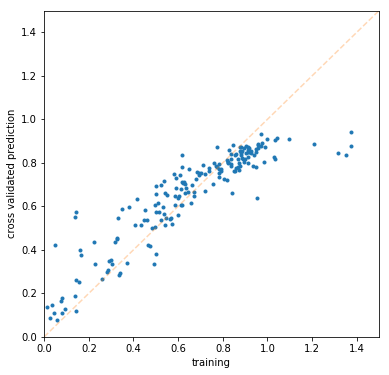

In [30]:
plot_train_pred(y, randfor_reg.predict(X_prep), lim)

In [31]:
mean_squared_error(y, randfor_reg.predict(X_prep))

0.0175444827464045

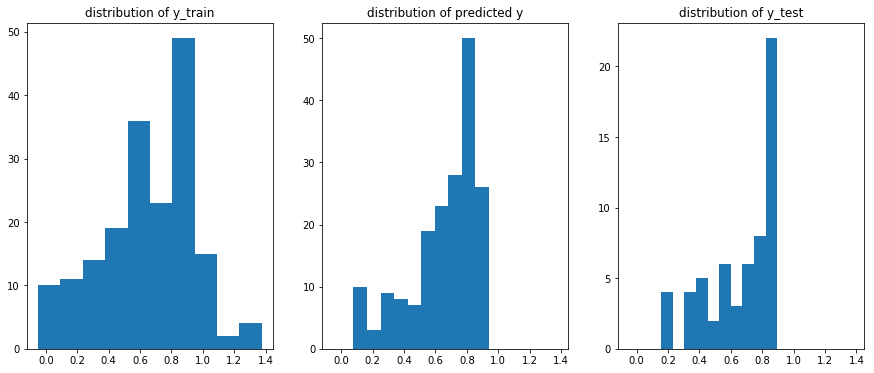

In [32]:
plot_pred_distribution(y, randfor_reg.predict(X_prep), randfor_reg.predict(X_test_prep))

In [33]:
pd.DataFrame(
    randfor_reg.predict(X_test_prep), 
    index=X_test.droplevel('Organism Code').index, 
    columns=['pred'], 
    dtype='float'
).to_csv('../output/submission/perf_TTF07N_randfor_refit_with_val.csv')

In [34]:
joblib.dump(ada_reg, '../models/submission/perf_TTF07N_randfor_refit_with_val.pkl')

['../models/submission/perf_TTF07N_randfor_refit_with_val.pkl']

This prediction got an MSE `0.0158` in test set.